In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set(font_scale=1.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [3]:
df = pd.DataFrame()
for filename in glob.glob('./DATABASE/*.json'):
    with open(filename) as json_file:
        data = json.load(json_file)
        new = json_normalize(data['log_monitoring'][0]['contents'])
        df= pd.concat([df, new])

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [4]:
ind = np.arange(0, len(df), 1)
ind = pd.Series(ind)
df['index_run'] = ind.values
df = df.set_index('index_run')

In [5]:
df.head()

creation_time                                      err_log  \
index_run                                                                     
0          2020-01-12T23:42:42                     [before wrap up\n ok, 0]   
1          2019-09-09T04:36:55                     [before wrap up\n ok, 0]   
2          2020-01-12T23:45:15                     [before wrap up\n ok, 0]   
3          2020-01-12T18:07:06                     [before wrap up\n ok, 0]   
4          2020-05-03T11:11:17  [wall dist ok,\n before other preproc, 290]   

          params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           20000000               no                                no   
1           70000000            smago                             colin   
2           20000000               no                                no   
3           20000000               no                                no   
4           70000000            smago                     colin_species   

          params.convection_scheme params.mixture_name params.ncell_group  \
index_run                                                                   
0                               LW                 AIR                100   
1                               LW                 AIR                 40   
2                               LW                 AIR                100   
3                            TTG4A                 AIR                100   
4                             TTGC                C3H8                 60   

          params.partitioner  params.reactive_flow  ...  vars.MPI_processes  \
index_run                                           ...                       
0                   parmetis                   0.0  ...                 1.0   
1                   parmetis                   0.0  ...                 2.0   
2                   parmetis                   0.0  ...                 2.0   
3                   parmetis                   0.0  ...                36.0   
4                   parmetis                   1.0  ...               540.0   

          vars.dimension vars.elapsed_time  vars.final_iteration  \
index_run                                                          
0                    1.0              1.00                3841.0   
1                    2.0              2.00              800000.0   
2                    2.0              2.00                4801.0   
3                    2.0              1.45                3840.0   
4                    2.0          41997.24             1439505.0   

          vars.initial_iteration  vars.initial_time  vars.nodes  \
index_run                                                         
0                            1.0                1.0         1.0   
1                            2.0                2.0         2.0   
2                            2.0                2.0         2.0   
3                            0.0                0.0      1802.0   
4                            0.0                0.0    961367.0   

           vars.number_of_probes  vars.physical_time  vars.time_per_ite  
index_run                                                                
0                            NaN            1.000000             1.0000  
1                            NaN            2.000000             2.0000  
2                            NaN            2.000000             2.0000  
3                            NaN            0.005760             0.0002  
4                            6.0            0.008447            83.2870  

[5 rows x 26 columns]

In [6]:
df.columns

Index(['creation_time', 'err_log', 'params.CFL', 'params.LES_model',
       'params.artificial_viscosity_model', 'params.convection_scheme',
       'params.mixture_name', 'params.ncell_group', 'params.partitioner',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version',
       'vars.CPU_time_s', 'vars.MPI_processes', 'vars.dimension',
       'vars.elapsed_time', 'vars.final_iteration', 'vars.initial_iteration',
       'vars.initial_time', 'vars.nodes', 'vars.number_of_probes',
       'vars.physical_time', 'vars.time_per_ite'],
      dtype='object')

# some filling of NaN values

In [7]:
df.isnull().sum()

creation_time                           0
err_log                                 0
params.CFL                              0
params.LES_model                        0
params.artificial_viscosity_model       0
params.convection_scheme                0
params.mixture_name                     0
params.ncell_group                      8
params.partitioner                      9
params.reactive_flow                    3
params.real_gas                       752
params.smu2                          1484
params.solver_type                      0
params.two_phase_flow                2922
vars.AVBP_version                      46
vars.CPU_time_s                       182
vars.MPI_processes                     51
vars.dimension                          9
vars.elapsed_time                     167
vars.final_iteration                  173
vars.initial_iteration                 11
vars.initial_time                      11
vars.nodes                             10
vars.number_of_probes             

In [8]:
# un run qui a Nan en nb of probes est un run qui n'a pas de probes
df['vars.number_of_probes'] = df['vars.number_of_probes'].fillna(0.0)
df['params.real_gas'] = df['params.real_gas'].fillna(0.0)
# un run qui n'a pas tourné a 0 en CPU_time ...
df['vars.CPU_time_s'] = df['vars.CPU_time_s'].fillna(0.0)
df['params.two_phase_flow'] = df['params.two_phase_flow'].fillna(0.0)
df['vars.physical_time'] = df['vars.physical_time'].fillna(0.0)
df['vars.elapsed_time'] = df['vars.elapsed_time'].fillna(0.0)
df['vars.final_iteration'] = df['vars.final_iteration'].fillna(0.0)
df['vars.initial_time'] = df['vars.initial_time'].fillna(0.0)
df['params.smu2'] = df['params.smu2'].fillna(0.0)

In [9]:
# si LES = no alors on remplace par DNS.
df['params.LES_model'] = df['params.LES_model'].apply(lambda x: 'DNS' if x=='no' else x )

In [10]:
# traitement de la redondance Colin_species vs colin_species
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'colin_species' if x == 'Colin_species' else x)

In [11]:
df.isnull().sum()

creation_time                          0
err_log                                0
params.CFL                             0
params.LES_model                       0
params.artificial_viscosity_model      0
params.convection_scheme               0
params.mixture_name                    0
params.ncell_group                     8
params.partitioner                     9
params.reactive_flow                   3
params.real_gas                        0
params.smu2                            0
params.solver_type                     0
params.two_phase_flow                  0
vars.AVBP_version                     46
vars.CPU_time_s                        0
vars.MPI_processes                    51
vars.dimension                         9
vars.elapsed_time                      0
vars.final_iteration                   0
vars.initial_iteration                11
vars.initial_time                      0
vars.nodes                            10
vars.number_of_probes                  0
vars.physical_ti

In [12]:
df = df.dropna(subset=['vars.nodes'])

In [13]:
df['mesh_cells'] = df['vars.nodes'].apply(lambda x : int(x/3))

In [14]:
df = df.dropna(subset=['vars.time_per_ite'])

In [15]:
df = df.dropna(subset=['vars.MPI_processes'])
df = df.dropna(subset=['params.ncell_group'])

In [16]:
df['vars.nodes'] = df['vars.nodes'].apply(lambda x: int(x))

In [17]:
df['vars.dimension'] = df['vars.dimension'].apply(lambda x: int(x))

In [18]:
df['vars.MPI_processes'] = df['vars.MPI_processes'].apply(lambda x: int(x))

In [19]:
df['vars.time_per_ite'] = df['vars.time_per_ite'].fillna(0.0)
df['params.ncell_group'] = df['params.ncell_group'].apply(lambda x: int(x))
df['params.smu2'] = df['params.smu2'].apply(lambda x: float(x))

In [20]:
df = df.dropna()

In [21]:
df.dtypes

creation_time                         object
err_log                               object
params.CFL                            object
params.LES_model                      object
params.artificial_viscosity_model     object
params.convection_scheme              object
params.mixture_name                   object
params.ncell_group                     int64
params.partitioner                    object
params.reactive_flow                 float64
params.real_gas                      float64
params.smu2                          float64
params.solver_type                    object
params.two_phase_flow                float64
vars.AVBP_version                     object
vars.CPU_time_s                      float64
vars.MPI_processes                     int64
vars.dimension                         int64
vars.elapsed_time                    float64
vars.final_iteration                 float64
vars.initial_iteration               float64
vars.initial_time                    float64
vars.nodes

# Separation en deux dataframes

## creation de deux dataframe, un pour le setup, un pour le résultat 

On sépare le dataframe en un dataframe de setup du run , majoritairement les parametres lus dans run.params, et un dataframe qui contient plus des valeurs qui sortent du avbp.o

In [22]:
run_setup = ['params.CFL', 'params.LES_model',
       'params.artificial_viscosity_model', 'params.convection_scheme',
       'params.mixture_name', 'params.ncell_group', 'params.partitioner',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version', 'vars.MPI_processes', 'vars.dimension', 
       'vars.nodes', 'vars.number_of_probes']

In [23]:
run_result = ['creation_time', 'err_log','vars.CPU_time_s', 'vars.elapsed_time', 'vars.final_iteration', 'vars.initial_iteration',
       'vars.initial_time', 'vars.physical_time', 'vars.time_per_ite' ]

In [24]:
df_setup = df[run_setup]

In [25]:
df_log = df[run_result]

In [26]:
df_setup.transpose()

index_run                              0         1         2         3     \
params.CFL                         20000000  70000000  20000000  20000000   
params.LES_model                        DNS     smago       DNS       DNS   
params.artificial_viscosity_model        no     colin        no        no   
params.convection_scheme                 LW        LW        LW     TTG4A   
params.mixture_name                     AIR       AIR       AIR       AIR   
params.ncell_group                      100        40       100       100   
params.partitioner                 parmetis  parmetis  parmetis  parmetis   
params.reactive_flow                      0         0         0         0   
params.real_gas                           0         0         0         0   
params.smu2                               0         0         0         0   
params.solver_type                    Euler        ns     Euler     Euler   
params.two_phase_flow                     0         0         0         0   
vars.AVBP_version                     7.5.0     7.3.0     7.5.0     7.5.0   
vars.MPI_processes                        1         2         2        36   
vars.dimension                            1         2         2         2   
vars.nodes                                1         2         2      1802   
vars.number_of_probes                     0         0         0         0   

index_run                                   4         5         6     \
params.CFL                              70000000  20000000  20000000   
params.LES_model                           smago       DNS       DNS   
params.artificial_viscosity_model  colin_species   Jameson        no   
params.convection_scheme                    TTGC        LW     TTG4A   
params.mixture_name                         C3H8       AIR       AIR   
params.ncell_group                            60       100       100   
params.partitioner                      parmetis  parmetis  parmetis   
params.reactive_flow                           1         0         0   
params.real_gas                                0         0         0   
params.smu2                                    0         0         0   
params.solver_type                            ns     Euler     Euler   
params.two_phase_flow                          0         0         0   
vars.AVBP_version                          7.6.0     7.5.0     7.5.0   
vars.MPI_processes                           540         2        36   
vars.dimension                                 2         2         2   
vars.nodes                                961367         2      4952   
vars.number_of_probes                          6         0         0   

index_run                              8           9         10    ...  \
params.CFL                         20000000    70000000  20000000  ...   
params.LES_model                        DNS       sigma       DNS  ...   
params.artificial_viscosity_model        no       colin        no  ...   
params.convection_scheme              TTG4A        TTGC     TTG4A  ...   
params.mixture_name                     AIR  KERO_LUCHE       AIR  ...   
params.ncell_group                      100         100       100  ...   
params.partitioner                 parmetis    parmetis  parmetis  ...   
params.reactive_flow                      0           1         0  ...   
params.real_gas                           0           0         0  ...   
params.smu2                               0           1         0  ...   
params.solver_type                    Euler          ns     Euler  ...   
params.two_phase_flow                     0           0         0  ...   
vars.AVBP_version                     7.3.0       7.3.0     7.5.0  ...   
vars.MPI_processes                        2         360         2  ...   
vars.dimension                            2           3         2  ...   
vars.nodes                                2     8064050         2  ...   
vars.number_of_probes                     0         122   

In [27]:
df_setup.head()

params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           20000000              DNS                                no   
1           70000000            smago                             colin   
2           20000000              DNS                                no   
3           20000000              DNS                                no   
4           70000000            smago                     colin_species   

          params.convection_scheme params.mixture_name  params.ncell_group  \
index_run                                                                    
0                               LW                 AIR                 100   
1                               LW                 AIR                  40   
2                               LW                 AIR                 100   
3                            TTG4A                 AIR                 100   
4                             TTGC                C3H8                  60   

          params.partitioner  params.reactive_flow  params.real_gas  \
index_run                                                             
0                   parmetis                   0.0              0.0   
1                   parmetis                   0.0              0.0   
2                   parmetis                   0.0              0.0   
3                   parmetis                   0.0              0.0   
4                   parmetis                   1.0              0.0   

           params.smu2 params.solver_type  params.two_phase_flow  \
index_run                                                          
0                  0.0              Euler                    0.0   
1                  0.0                 ns                    0.0   
2                  0.0              Euler                    0.0   
3                  0.0              Euler                    0.0   
4                  0.0                 ns                    0.0   

          vars.AVBP_version  vars.MPI_processes  vars.dimension  vars.nodes  \
index_run                                                                     
0                     7.5.0                   1               1           1   
1                     7.3.0                   2               2           2   
2                     7.5.0                   2               2           2   
3                     7.5.0                  36               2        1802   
4                     7.6.0                 540               2      961367   

           vars.number_of_probes  
index_run                         
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            6.0

In [28]:
df_log.head()

creation_time                                      err_log  \
index_run                                                                     
0          2020-01-12T23:42:42                     [before wrap up\n ok, 0]   
1          2019-09-09T04:36:55                     [before wrap up\n ok, 0]   
2          2020-01-12T23:45:15                     [before wrap up\n ok, 0]   
3          2020-01-12T18:07:06                     [before wrap up\n ok, 0]   
4          2020-05-03T11:11:17  [wall dist ok,\n before other preproc, 290]   

           vars.CPU_time_s  vars.elapsed_time  vars.final_iteration  \
index_run                                                             
0             6.217000e+00               1.00                3841.0   
1             2.720000e+06               2.00              800000.0   
2             2.435000e+02               2.00                4801.0   
3             5.208000e+01               1.45                3840.0   
4             2.268000e+07           41997.24             1439505.0   

           vars.initial_iteration  vars.initial_time  vars.physical_time  \
index_run                                                                  
0                             1.0                1.0            1.000000   
1                             2.0                2.0            2.000000   
2                             2.0                2.0            2.000000   
3                             0.0                0.0            0.005760   
4                             0.0                0.0            0.008447   

           vars.time_per_ite  
index_run                     
0                     1.0000  
1                     2.0000  
2                     2.0000  
3                     0.0002  
4                    83.2870

In [29]:
df.isnull().sum()

creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   0
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               0
vars.initial_time                    0
vars.nodes                           0
vars.number_of_probes                0
vars.physical_time                   0
vars.time_per_ite        

# Number of runs depending of the dimension

In [30]:
# calcul de l'efficacité (temps passé par coeur /itération pour calculer un point), on sépare par dimension (2D et 3D)
#df['eff'] = df['vars.time_per_ite']*1000000/df['vars.nodes']
df_3D = df[df['vars.dimension'] == 3]
df_2D = df[df['vars.dimension'] == 2]
df_3D['eff'] = df_3D['vars.time_per_ite']*1000000/df_3D['vars.nodes']
df_2D['eff'] = df_2D['vars.time_per_ite']*1000000/df_2D['vars.nodes']

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Work on error log

We add a column with the error code (to be continued), if the error code is 0, it means that the run is converged.
so we create a column 'CONVERGED' which can take the value 0 or 1.

In [31]:
df['error_code'] = df['err_log'].apply(lambda x: str(x).split(',')[-1][:-1].rstrip())

In [32]:
df['error_code'][0]

' 0'

In [33]:
def conversion(x):
    if x ==' 0':
        return 1
    else:
        return 0

In [34]:
df['converged'] = df['error_code'].apply(conversion)

In [35]:
df['converged']

index_run
0       1
1       1
2       1
3       1
4       0
5       1
6       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
31      1
       ..
3186    1
3188    1
3189    1
3190    1
3191    1
3192    1
3193    1
3194    1
3195    1
3197    1
3198    1
3199    1
3200    1
3201    1
3202    1
3203    1
3204    1
3205    1
3206    1
3207    1
3208    1
3209    1
3210    1
3211    1
3212    1
3213    1
3214    1
3215    1
3216    1
3217    1
Name: converged, Length: 2992, dtype: int64

In [36]:
df[df['converged']==0]

creation_time                                      err_log  \
index_run                                                                     
4          2020-05-03T11:11:17  [wall dist ok,\n before other preproc, 290]   
37         2020-03-05T11:25:47                     [before run params, 110]   
56         2020-01-12T23:09:14                     [before run params, 110]   
78         2019-06-27T15:32:07                     [before run params, 110]   
169        2020-05-08T14:37:26  [wall dist ok,\n before other preproc, 290]   
216        2019-05-08T23:23:37                     [before run params, 110]   
249        2019-02-14T15:19:26                     [before run params, 110]   
283        2020-05-15T17:44:04                     [before run params, 110]   
288        2020-05-15T17:44:03                     [before run params, 110]   
303        2019-12-18T09:35:52                     [before run params, 110]   
314        2019-05-08T23:20:07                     [before run params, 110]   
315        2019-10-17T17:38:19                     [before run params, 110]   
331        2020-07-22T05:12:03  [wall dist ok,\n before other preproc, 290]   
382        2019-02-26T20:28:31                  [before temporal loop, 300]   
433        2020-04-20T15:34:56                     [before run params, 110]   
445        2019-05-09T00:01:30                     [before run params, 110]   
496        2020-04-29T02:22:36  [wall dist ok,\n before other preproc, 290]   
508        2019-05-08T23:39:51                     [before run params, 110]   
523        2020-02-19T17:51:23                     [before run params, 110]   
533        2019-10-10T23:30:42                     [before run params, 110]   
639        2019-02-07T11:08:14                     [before run params, 110]   
650        2020-02-12T16:35:30                     [before run params, 110]   
669        2019-02-14T15:19:17                     [before run params, 110]   
736        2019-08-07T11:37:06                  [before temporal loop, 300]   
737        2020-06-10T16:31:52  [wall dist ok,\n before other preproc, 290]   
804        2020-07-05T18:35:11                     [before run params, 110]   
806        2019-05-08T23:36:37                     [before run params, 110]   
917        2019-12-18T09:12:16                     [before run params, 110]   
937        2020-07-24T15:12:43  [wall dist ok,\n before other preproc, 290]   
996        2019-10-10T15:07:11                     [before run params, 110]   
...                        ...                                          ...   
2115       2020-06-05T10:22:31  [wall dist ok,\n before other preproc, 290]   
2116       2020-01-12T22:39:05                     [before run params, 110]   
2126       2019-12-16T16:52:44                     [before run params, 110]   
2130       2020-04-17T14:54:26                     [before run params, 110]   
2169       2019-06-24T10:46:30                     [before run params, 110]   
2217       2020-07-02T12:36:38  [wall dist ok,\n before other preproc, 290]   
2351       2019-02-07T11:08:05                     [before run params, 110]   
2377       2019-01-15T15:50:48                     [before run params, 110]   
2387       2019-10-10T14:55:03                     [before run params, 110]   
2458       2019-07-11T15:05:15                     [before run params, 110]   
2484       2018-10-16T16:31:29                  [before temporal loop, 300]   
2490       2020-08-13T14:10:33                     [before run params, 110]   
2506       2019-12-10T18:09:38                     [before run params, 110]   
2527       2019-10-10T23:30:42                     [before run params, 110]   
2625       2020-02-12T15:41:07                     [before run params, 110]   
2651       2019-12-16T17:27:00                     [before run params, 110]   
2817       2020-01-08T15:23:23                     [before run params, 110]   
2823       2020-07-18T04:23:45  [wall dist ok,\n before other prepr

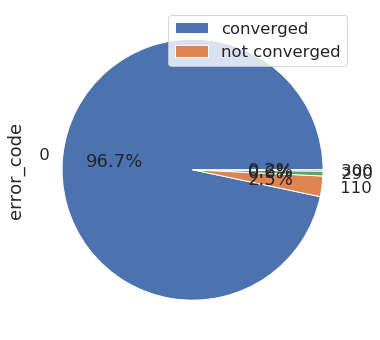

In [37]:
fig = plt.figure(figsize = (10,6))
df['error_code'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
state=['converged', 'not converged']
plt.legend(['converged', 'not converged'])
#plt.legend(loc = 1)

## PCA on setup

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [39]:
df_setup.columns

Index(['params.CFL', 'params.LES_model', 'params.artificial_viscosity_model',
       'params.convection_scheme', 'params.mixture_name', 'params.ncell_group',
       'params.partitioner', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.solver_type', 'params.two_phase_flow',
       'vars.AVBP_version', 'vars.MPI_processes', 'vars.dimension',
       'vars.nodes', 'vars.number_of_probes'],
      dtype='object')

In [40]:
df_pca = df[run_setup]
df_pca_c = pd.concat([df[run_setup], df['converged']], axis = 1)
df_pca = df_pca_c

In [41]:
df_pca.head()

params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           20000000              DNS                                no   
1           70000000            smago                             colin   
2           20000000              DNS                                no   
3           20000000              DNS                                no   
4           70000000            smago                     colin_species   

          params.convection_scheme params.mixture_name  params.ncell_group  \
index_run                                                                    
0                               LW                 AIR                 100   
1                               LW                 AIR                  40   
2                               LW                 AIR                 100   
3                            TTG4A                 AIR                 100   
4                             TTGC                C3H8                  60   

          params.partitioner  params.reactive_flow  params.real_gas  \
index_run                                                             
0                   parmetis                   0.0              0.0   
1                   parmetis                   0.0              0.0   
2                   parmetis                   0.0              0.0   
3                   parmetis                   0.0              0.0   
4                   parmetis                   1.0              0.0   

           params.smu2 params.solver_type  params.two_phase_flow  \
index_run                                                          
0                  0.0              Euler                    0.0   
1                  0.0                 ns                    0.0   
2                  0.0              Euler                    0.0   
3                  0.0              Euler                    0.0   
4                  0.0                 ns                    0.0   

          vars.AVBP_version  vars.MPI_processes  vars.dimension  vars.nodes  \
index_run                                                                     
0                     7.5.0                   1               1           1   
1                     7.3.0                   2               2           2   
2                     7.5.0                   2               2           2   
3                     7.5.0                  36               2        1802   
4                     7.6.0                 540               2      961367   

           vars.number_of_probes  converged  
index_run                                    
0                            0.0          1  
1                            0.0          1  
2                            0.0          1  
3                            0.0          1  
4                            6.0          0

In [42]:
dummies_mixturename = pd.get_dummies(df_pca['params.mixture_name'])
df_pca = pd.concat([df_pca.drop('params.mixture_name', axis = 1), dummies_mixturename], axis=1)

In [43]:
df_pca.head()

params.CFL params.LES_model params.artificial_viscosity_model  \
index_run                                                                 
0           20000000              DNS                                no   
1           70000000            smago                             colin   
2           20000000              DNS                                no   
3           20000000              DNS                                no   
4           70000000            smago                     colin_species   

          params.convection_scheme  params.ncell_group params.partitioner  \
index_run                                                                   
0                               LW                 100           parmetis   
1                               LW                  40           parmetis   
2                               LW                 100           parmetis   
3                            TTG4A                 100           parmetis   
4                             TTGC                  60           parmetis   

           params.reactive_flow  params.real_gas  params.smu2  \
index_run                                                       
0                           0.0              0.0          0.0   
1                           0.0              0.0          0.0   
2                           0.0              0.0          0.0   
3                           0.0              0.0          0.0   
4                           1.0              0.0          0.0   

          params.solver_type  ...  CH4_LU_19 GRI30  H2_O2  KERO_LUCHE  N2  \
index_run                     ...                                           
0                      Euler  ...          0     0      0           0   0   
1                         ns  ...          0     0      0           0   0   
2                      Euler  ...          0     0      0           0   0   
3                      Euler  ...          0     0      0           0   0   
4                         ns  ...          0     0      0           0   0   

           N2_qpf  N2_qpf_poiseuille  N2_qpf_poiseuille_2D  O2  O2N2  
index_run                                                             
0               0                  0                     0   0     0  
1               0                  0                     0   0     0  
2               0                  0                     0   0     0  
3               0                  0                     0   0     0  
4               0                  0                     0   0     0  

[5 rows x 37 columns]

In [44]:
#On supprime les colonnes qui n'ont aucune variabilité.
df_pca = df_pca.drop('params.solver_type', axis = 1)
df_pca = df_pca.drop('params.partitioner', axis = 1)
df_pca = df_pca.drop('params.CFL', axis = 1)

In [45]:
dummies_avbpversion = pd.get_dummies(df_pca['vars.AVBP_version'])
df_pca = pd.concat([df_pca.drop('vars.AVBP_version', axis = 1), dummies_avbpversion], axis=1)

dummies_viscoartif = pd.get_dummies(df_pca['params.artificial_viscosity_model'])
df_pca = pd.concat([df_pca.drop('params.artificial_viscosity_model', axis = 1), dummies_viscoartif], axis=1)
#'params.convection_scheme'
dummies_convection_scheme = pd.get_dummies(df_pca['params.convection_scheme'])
df_pca = pd.concat([df_pca.drop('params.convection_scheme', axis = 1), dummies_convection_scheme], axis=1)
                                    
#'params.LES_model'
dummies_LES_model = pd.get_dummies(df_pca['params.LES_model'])
df_pca = pd.concat([df_pca.drop('params.LES_model', axis = 1), dummies_LES_model], axis=1)                                                       
#                       

In [46]:
df_pca = df_pca.dropna()

In [47]:
# on peut supprimer le nombre de probes si on pense que on nve vuet pas classer par rapport à cette variable
df_pca = df_pca.drop('vars.number_of_probes', axis = 1)

In [48]:
df_pca_c = df_pca
df_pca = df_pca.drop('converged', axis = 1)

In [49]:
print(len(df_pca_c))

2992


In [50]:
df_pca.columns

Index(['params.ncell_group', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.two_phase_flow', 'vars.MPI_processes',
       'vars.dimension', 'vars.nodes', '1S_C3H8_BFER', '2S_propane', 'AIR',
       'AIR_QPF_Vortex', 'C3H8', 'C3H8_22_173_12_FC', 'C3H8_23_173_10_PP',
       'CH4', 'CH4_19_177_11_LU', 'CH4_19_184_11_LU', 'CH4_LU_19', 'GRI30',
       'H2_O2', 'KERO_LUCHE', 'N2', 'N2_qpf', 'N2_qpf_poiseuille',
       'N2_qpf_poiseuille_2D', 'O2', 'O2N2', '7.1.0', '7.2.0', '7.3.0',
       '7.4.0', '7.5.0', '7.6.0', 'Jameson', 'colin', 'colin_rhou',
       'colin_rhou_species', 'colin_species', 'honey', 'jameson', 'no', 'LW',
       'LW_FE', 'RK3', 'RK4', 'RK5', 'TTG4A', 'TTGC', 'boundary_terms', 'DNS',
       'sigma', 'smago', 'smagodyn', 'wale'],
      dtype='object')

In [51]:
print(len(df_pca), len(df_pca_c))

2992 2992


Now we have a dataframe containing only numerical values, with no null values.

In [52]:
# we can look at what features have the most standard deviation --> it yields vars.nodes, MPI_processes, 
#number of probes () but number of probes we know that is not really relevant.
df_pca.std().sort_values()

params.real_gas          0.000000e+00
params.two_phase_flow    0.000000e+00
GRI30                    1.828181e-02
2S_propane               1.828181e-02
N2_qpf_poiseuille        1.828181e-02
H2_O2                    1.828181e-02
N2_qpf_poiseuille_2D     1.828181e-02
C3H8_23_173_10_PP        1.828181e-02
smagodyn                 1.828181e-02
CH4_19_177_11_LU         1.828181e-02
CH4_19_184_11_LU         2.585006e-02
RK4                      2.585006e-02
colin_rhou_species       3.165444e-02
C3H8_22_173_12_FC        3.165444e-02
honey                    3.654528e-02
1S_C3H8_BFER             4.474366e-02
O2                       6.321349e-02
N2                       7.294364e-02
colin_rhou               7.734242e-02
7.4.0                    7.734242e-02
AIR_QPF_Vortex           7.944842e-02
boundary_terms           8.544774e-02
KERO_LUCHE               9.798866e-02
C3H8                     9.964698e-02
colin_species            9.964698e-02
wale                     1.060107e-01
CH4_LU_19   

In [53]:
#we create an instance of PCA: we want to determine how many PCA components
#allow to keep 80 % of the standard deviation of the data
pca = PCA(n_components = 7)
# standardScaler, for each variable, withdraws the mean value and divides by std()
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data

array([[-0.45856647, -0.22485951,  0.        , ..., -0.471934  ,
        -0.01828487, -0.10721125],
       [-0.47461799, -0.22485951,  0.        , ...,  2.11894036,
        -0.01828487, -0.10721125],
       [-0.45856647, -0.22485951,  0.        , ..., -0.471934  ,
        -0.01828487, -0.10721125],
       ...,
       [-0.47568809, -0.22485951,  0.        , ..., -0.471934  ,
        -0.01828487, -0.10721125],
       [-0.45856647, -0.22485951,  0.        , ..., -0.471934  ,
        -0.01828487, -0.10721125],
       [-0.45856647, -0.22485951,  0.        , ..., -0.471934  ,
        -0.01828487, -0.10721125]])

In [54]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [55]:
len(pca.explained_variance_ratio_)

7

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Standard Deviation kept (%)')

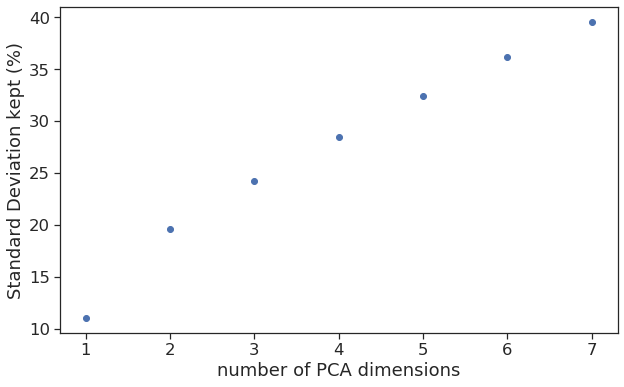

In [56]:
fig = plt.figure(figsize=(10,6))
plt.scatter(np.arange(1,8), 100*pca.explained_variance_ratio_.cumsum())
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('number of PCA dimensions')
ax.set_ylabel('Standard Deviation kept (%)')

#### We now know that we need about 3 or 4 elements in PCA to keep the standard deviation.

## PCA with 2 components

In [57]:
pca = PCA(n_components = 2)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True),
                     pd.DataFrame(scores_pca, 
                     columns = ['Component 1', 'Component 2'])], axis = 1)

In [58]:
df_comp

params.ncell_group  params.reactive_flow  params.real_gas  params.smu2  \
0                    100                   0.0              0.0          0.0   
1                     40                   0.0              0.0          0.0   
2                    100                   0.0              0.0          0.0   
3                    100                   0.0              0.0          0.0   
4                     60                   1.0              0.0          0.0   
5                    100                   0.0              0.0          0.0   
6                    100                   0.0              0.0          0.0   
7                    100                   0.0              0.0          0.0   
8                    100                   1.0              0.0          1.0   
9                    100                   0.0              0.0          0.0   
10                   100                   0.0              0.0          0.0   
11                   100                   0.0              0.0          0.0   
12                   100                   0.0              0.0          0.0   
13                   100                   0.0              0.0          0.0   
14                   100                   0.0              0.0          0.0   
15                   400                   0.0              0.0          0.0   
16                   100                   0.0              0.0          0.0   
17                 10000                   0.0              0.0          0.0   
18                   100                   0.0              0.0          0.0   
19                   100                   1.0              0.0          1.0   
20                 10000                   0.0              0.0          0.0   
21                   100                   0.0              0.0          0.0   
22                 10000                   0.0              0.0          0.0   
23                 10000                   0.0              0.0          0.0   
24                   100                   0.0              0.0          0.0   
25                   100                   0.0              0.0          0.0   
26                   100                   0.0              0.0          0.0   
27                    60                   1.0              0.0          0.0   
28                    40                   0.0              0.0          0.0   
29                   100                   0.0              0.0          0.0   
...                  ...                   ...              ...          ...   
2962                 100                   0.0              0.0          0.0   
2963                 100                   0.0              0.0          0.0   
2964                 100                   0.0              0.0          0.0   
2965                 100                   0.0              0.0          0.0   
2966                 100                   0.0              0.0          0.0   
2967               10000                   0.0              0.0          0.0   
2968                 100                   0.0              0.0          0.0   
2969                 100                   0.0              0.0          0.0   
2970                 100                   0.0              0.0          0.0   
2971                 100                   0.0              0.0          0.0   
2972                  40                   1.0              0.0          0.0   
2973                 100                   0.0              0.0          0.0   
2974                 100                   0.0              0.0          0.0   
2975                 100                   0.0              0.0          0.0   
2976                 100                   0.0              0.0          0.0   
2977                 100                   0.0              0.0          0.0   
2978               10000                   0.0              0.0          0.0   
2979                 100                   0.0              0.0          0.0   
2980  

In [59]:
df_pca.columns

Index(['params.ncell_group', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.two_phase_flow', 'vars.MPI_processes',
       'vars.dimension', 'vars.nodes', '1S_C3H8_BFER', '2S_propane', 'AIR',
       'AIR_QPF_Vortex', 'C3H8', 'C3H8_22_173_12_FC', 'C3H8_23_173_10_PP',
       'CH4', 'CH4_19_177_11_LU', 'CH4_19_184_11_LU', 'CH4_LU_19', 'GRI30',
       'H2_O2', 'KERO_LUCHE', 'N2', 'N2_qpf', 'N2_qpf_poiseuille',
       'N2_qpf_poiseuille_2D', 'O2', 'O2N2', '7.1.0', '7.2.0', '7.3.0',
       '7.4.0', '7.5.0', '7.6.0', 'Jameson', 'colin', 'colin_rhou',
       'colin_rhou_species', 'colin_species', 'honey', 'jameson', 'no', 'LW',
       'LW_FE', 'RK3', 'RK4', 'RK5', 'TTG4A', 'TTGC', 'boundary_terms', 'DNS',
       'sigma', 'smago', 'smagodyn', 'wale'],
      dtype='object')

In [60]:
df_pcacomponents = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
df_pcacomponents

params.ncell_group  params.reactive_flow  params.real_gas  params.smu2  \
0            0.274418              0.205796     1.855571e-20     0.170908   
1            0.303502              0.332986     6.458608e-20     0.254953   

   params.two_phase_flow  vars.MPI_processes  vars.dimension  vars.nodes  \
0           2.028143e-21            0.217795        0.210134    0.110622   
1           6.328594e-20            0.274031        0.105577    0.154388   

   1S_C3H8_BFER  2S_propane  ...       RK4       RK5     TTG4A      TTGC  \
0      0.027546    0.016381  ...  0.008028  0.094374  0.153804  0.057396   
1      0.017657    0.001840  ...  0.011662  0.111985  0.033939  0.053893   

   boundary_terms       DNS     sigma     smago  smagodyn      wale  
0        0.020238  0.355501  0.135384  0.297256  0.007665  0.098499  
1        0.026315  0.136885  0.202274  0.259500  0.008378  0.092410  

[2 rows x 55 columns]

Text(106.5, 0.5, "['PCA Componant 1', 'PCA Componant 2']")

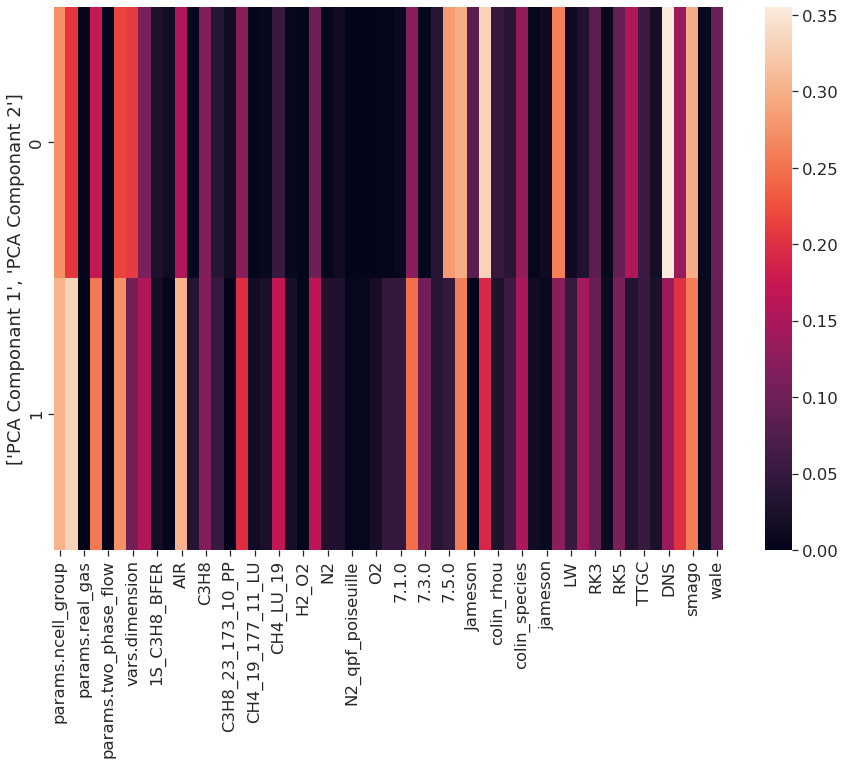

In [61]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
sns.heatmap(df_pcacomponents)
ax.set_ylabel(['PCA Componant 1', 'PCA Componant 2'])

In [62]:
np.transpose(pca.components_)

array([[ 2.74418446e-01, -3.03502239e-01],
       [ 2.05795919e-01,  3.32985952e-01],
       [ 1.85557111e-20,  6.45860797e-20],
       [ 1.70908026e-01,  2.54952504e-01],
       [ 2.02814292e-21, -6.32859403e-20],
       [ 2.17794509e-01,  2.74031123e-01],
       [ 2.10134482e-01,  1.05576687e-01],
       [ 1.10621661e-01,  1.54387701e-01],
       [ 2.75456477e-02,  1.76568712e-02],
       [ 1.63811035e-02,  1.84009854e-03],
       [-1.52948146e-01, -3.03538217e-01],
       [-6.12617444e-03,  3.56561123e-02],
       [ 1.15662281e-01,  1.18034038e-01],
       [ 3.64662774e-02,  5.20071006e-02],
       [ 1.63805122e-02,  1.82948002e-03],
       [ 1.22645446e-01,  1.99595311e-01],
       [ 2.68276622e-03,  1.59288309e-02],
       [ 7.94256736e-03,  2.44805284e-02],
       [ 5.39928396e-02,  1.70804468e-01],
       [ 5.98649515e-03,  2.35439456e-02],
       [ 1.75860194e-03,  3.17694622e-03],
       [ 9.96830233e-02,  1.64818106e-01],
       [-5.34647813e-03,  2.94051145e-02],
       [ 1.

In [63]:
df_pca.columns[0]

'params.ncell_group'

In [64]:
def biplot(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PCA Component{}".format(1), size=14)
    plt.ylabel("PCA Component{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.4,0.4])
    plt.ylim([-0.4,0.4])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[-1.89670424  2.05954961 -1.44179748 ...  1.30904424 -1.80700264
 -1.44179748]
[-0.12545314 -1.43425933  0.10470674 ...  1.4858004   0.09578023
  0.10470674]
55


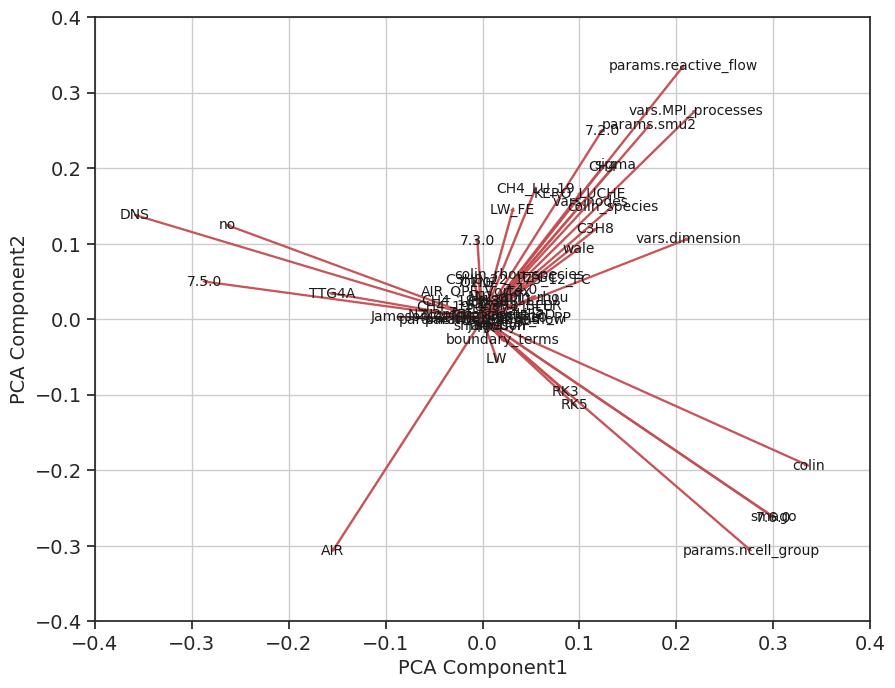

In [65]:
biplot(scores_pca, np.transpose(pca.components_))
plt.show()

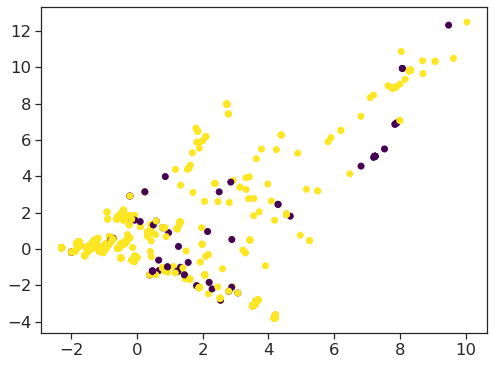

In [66]:
fig = plt.figure(figsize = (8,6))

plt.scatter(scores_pca[:,0], scores_pca[:,1], 
            c = df_pca_c['converged'], cmap = 'viridis')

## Determination du nombre de clusters optimal

In [67]:
from sklearn.cluster import KMeans

In [68]:
# on ne connait pas au préalable le nombre de clusters dans les runs
#on va maintenant montrer que le nombre de cluster optimal est bien 3
# Inertia is the sum of squared distances of samples to their closest cluster centre avec la donnée kmeans.inertia_

distance = []
for i in range(1,6):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scores_pca)
    distance.append(kmeans.inertia_)

Text(0, 0.5, 'kmeans distance')

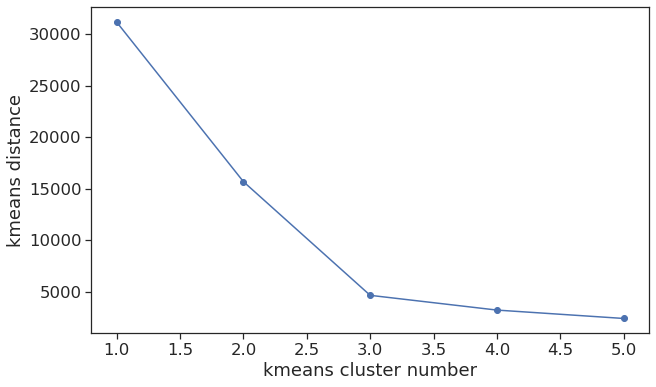

In [69]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1, 1)
plt.plot(range(1,6), distance, '-o')
ax.set_xlabel('kmeans cluster number')
ax.set_ylabel('kmeans distance')

We see that above 3 clusters in the kmeans model doesn't make the distance drop so much, so 3 is the optimal value.
We can deduce here that we have 3 big tendencies in our runs.

## Kmeans on PCA scores with Kmeans = 2

In [70]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[0 1 0 ... 0 0 0]


In [71]:
df_comp.columns

Index(['params.ncell_group', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.two_phase_flow', 'vars.MPI_processes',
       'vars.dimension', 'vars.nodes', '1S_C3H8_BFER', '2S_propane', 'AIR',
       'AIR_QPF_Vortex', 'C3H8', 'C3H8_22_173_12_FC', 'C3H8_23_173_10_PP',
       'CH4', 'CH4_19_177_11_LU', 'CH4_19_184_11_LU', 'CH4_LU_19', 'GRI30',
       'H2_O2', 'KERO_LUCHE', 'N2', 'N2_qpf', 'N2_qpf_poiseuille',
       'N2_qpf_poiseuille_2D', 'O2', 'O2N2', '7.1.0', '7.2.0', '7.3.0',
       '7.4.0', '7.5.0', '7.6.0', 'Jameson', 'colin', 'colin_rhou',
       'colin_rhou_species', 'colin_species', 'honey', 'jameson', 'no', 'LW',
       'LW_FE', 'RK3', 'RK4', 'RK5', 'TTG4A', 'TTGC', 'boundary_terms', 'DNS',
       'sigma', 'smago', 'smagodyn', 'wale', 'Component 1', 'Component 2',
       'k_means_pca'],
      dtype='object')

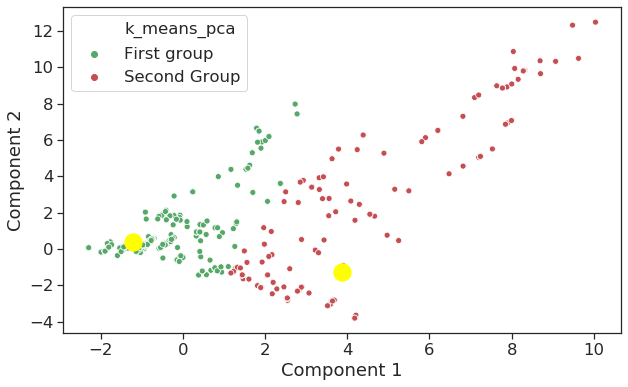

In [72]:
# With 2 components in PCA and kmeans
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group'})
fig = plt.figure(figsize = (10,6))
x = df_comp['Component 1']
y = df_comp['Component 2']
sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
                palette = ['g', 'r'])

plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            s=300, c='yellow', label = 'Centroids')

## Kmeans with 3 clusters 

In [73]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[0 1 0 ... 0 0 0]


In [74]:
kmeans.cluster_centers_.shape

(3, 2)

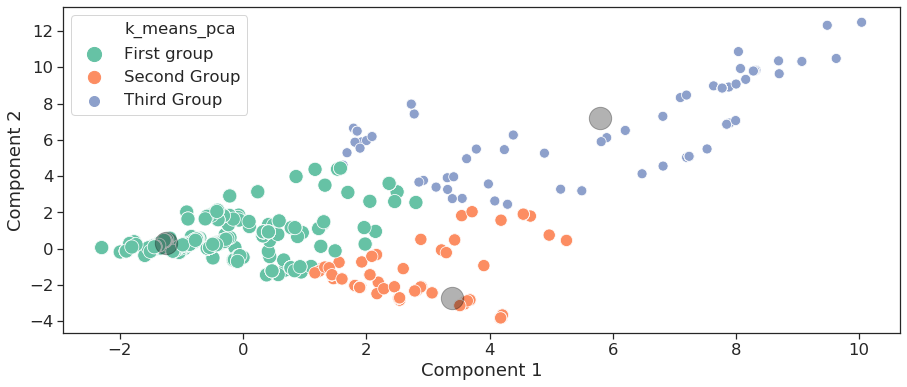

In [75]:
#ax = sns.scatterplot(x="total_bill", y="tip",
#                     hue="size", size="size",
##                     sizes=(20, 200), hue_norm=(0, 7),
#                     legend="full", data=tips)
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (15,6))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (100,200), palette="Set2")
#sns.scatterplot(x, y, hue = df_pca_c['converged'], 
#                palette="Set1", alpha = 0.4)
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

In [76]:
df_process_mean = df_comp.groupby('k_means_pca').mean()
df_process_mean

params.ncell_group  params.reactive_flow  params.real_gas  \
k_means_pca                                                               
First group           122.031915              0.007535              0.0   
Second Group         8546.079734              0.006645              0.0   
Third Group            57.910448              0.917910              0.0   

              params.smu2  params.two_phase_flow  vars.MPI_processes  \
k_means_pca                                                            
First group      0.000000                    0.0            8.898050   
Second Group     0.000000                    0.0           28.918605   
Third Group      0.328358                    0.0          359.761194   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  ...  \
k_means_pca                                                           ...   
First group         1.741135  4.616909e+04      0.000887    0.000000  ...   
Second Group        2.029900  8.669740e+04      0.004983    0.001661  ...   
Third Group         2.559701  3.724339e+06      0.007463    0.000000  ...   

                 TTG4A      TTGC  boundary_terms       DNS     sigma  \
k_means_pca                                                            
First group   0.295656  0.346188        0.003103  0.975177  0.017287   
Second Group  0.003322  0.332226        0.024917  0.132890  0.000000   
Third Group   0.022388  0.589552        0.000000  0.350746  0.343284   

                 smago  smagodyn      wale  Component 1  Component 2  
k_means_pca                                                           
First group   0.006649  0.000000  0.000887    -1.250284     0.292486  
Second Group  0.835548  0.001661  0.029900     3.396491    -2.702369  
Third Group   0.201493  0.000000  0.104478     5.790690     7.216249  

[3 rows x 57 columns]

In [77]:
df_comp2 = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2'], axis = 1)

In [78]:
df_process_std = df_comp2.groupby('k_means_pca').std()

In [79]:
dataframe = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'First group'].std(),
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(),
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
dataframe.sort_values(by ='Mean Third group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.nodes                46169.088209    339547.265049       86697.403654   
vars.MPI_processes            8.898050        15.508135          28.918605   
params.ncell_group          122.031915       310.602497        8546.079734   
vars.dimension                1.741135         0.454015           2.029900   
TTGC                          0.346188         0.475859           0.332226   
colin                         0.017287         0.130368           0.960133   
7.2.0                         0.000000         0.000000           0.003322   
DNS                           0.975177         0.155619           0.132890   
sigma                         0.017287         0.130368           0.000000   
params.smu2                   0.000000         0.000000           0.000000   
CH4                           0.005319         0.072754           0.000000   
CH4_LU_19                     0.000000         0.000000           0.000000   
no                            0.749113         0.433619           0.001661   
7.3.0                         0.222961         0.416325           0.038206   
colin_species                 0.000000         0.000000           0.000000   
C3H8                          0.000443         0.021054           0.000000   
smago                         0.006649         0.081287           0.835548   
LW_FE                         0.004876         0.069673           0.000000   
LW                            0.348848         0.476711           0.455150   
7.6.0                         0.031028         0.173433           0.951827   
KERO_LUCHE                    0.003546         0.059457           0.000000   
wale                          0.000887         0.029768           0.029900   
7.5.0                         0.726064         0.446075           0.000000   
7.4.0                         0.003546         0.059457           0.006645   
AIR                           0.922872         0.266853           0.991694   
C3H8_22_173_12_FC             0.000000         0.000000           0.000000   
TTG4A                         0.295656         0.456438           0.003322   
colin_rhou_species            0.000000         0.000000           0.000000   
colin_rhou                    0.000887         0.029768           0.023256   
GRI30                         0.000000         0.000000           0.000000   
honey                         0.001330         0.036450           0.000000   
1S_C3H8_BFER                  0.000887         0.029768           0.004983   
7.1.0                         0.016401         0.127039           0.000000   
CH4_19_184_11_LU              0.000443         0.021054           0.000000   
RK3                           0.001330         0.036450           0.083056   
boundary_terms                0.003103         0.055629           0.024917   
CH4_19_177_11_LU              0.000443         0.021054           0.000000   
C3H8_23_173_10_PP             0.000000         0.000000           0.001661   
smagodyn                      0.000000         0.000000           0.001661   
RK5                           0.000000         0.000000           0.098007   
RK4                           0.000000         0.000000           0.003322   
O2                            0.005319         0.072754           0.000000   
H2_O2                         0.000443         0.021054           0.000000   
O2N2                          0.027926         0.164796           0.000000   
N2                            0.007092         0.083935           0.000000   
2S_propane                    0.000000         0.000000           0.001661   
Jameson                       0.215869         0.411515           0.006645   
N2_qpf                        0.015957         0.125339           0.000000   
AIR_QPF_Vortex                0.008422         0.091404           0.000000   
N2_qpf_poiseuille             0.000443         0.021054           0.000000   
N2_qpf_poiseuille_2D          0.000443      

In [80]:
dataframe = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['First group', 'Second group', 'Third group']
dataframe

First group   Second group   Third group
params.ncell_group       310.602497    3516.765774  2.487486e+01
params.smu2                0.000000       0.000000  4.713781e-01
vars.MPI_processes        15.508135      75.621584  3.000734e+02
vars.dimension             0.454015       0.235959  4.982857e-01
vars.nodes            339547.265049  529116.719863  8.180101e+06
1S_C3H8_BFER               0.029768       0.070476  8.638684e-02
2S_propane                 0.000000       0.040757  0.000000e+00
AIR                        0.266853       0.090832  1.902399e-01
AIR_QPF_Vortex             0.091404       0.000000  0.000000e+00
C3H8                       0.021054       0.000000  4.133476e-01
C3H8_22_173_12_FC          0.000000       0.000000  1.484971e-01
C3H8_23_173_10_PP          0.000000       0.040757  0.000000e+00
CH4                        0.072754       0.000000  4.524277e-01
CH4_19_177_11_LU           0.021054       0.000000  0.000000e+00
CH4_19_184_11_LU           0.021054       0.000000  8.638684e-02
CH4_LU_19                  0.000000       0.000000  4.409338e-01
GRI30                      0.000000       0.000000  8.638684e-02
H2_O2                      0.021054       0.000000  0.000000e+00
KERO_LUCHE                 0.059457       0.000000  3.648973e-01
N2                         0.083935       0.000000  0.000000e+00
N2_qpf                     0.125339       0.000000  0.000000e+00
N2_qpf_poiseuille          0.021054       0.000000  0.000000e+00
N2_qpf_poiseuille_2D       0.021054       0.000000  0.000000e+00
O2                         0.072754       0.000000  0.000000e+00
O2N2                       0.164796       0.000000  0.000000e+00
7.1.0                      0.127039       0.000000  8.638684e-02
7.2.0                      0.000000       0.057591  4.982857e-01
7.3.0                      0.416325       0.191853  4.279538e-01
7.4.0                      0.059457       0.081310  2.075881e-01
7.5.0                      0.446075       0.000000  2.866106e-01
7.6.0                      0.173433       0.214309  3.848786e-01
Jameson                    0.411515       0.081310  0.000000e+00
colin                      0.130368       0.195810  5.009810e-01
colin_rhou                 0.029768       0.150840  1.217093e-01
colin_rhou_species         0.000000       0.000000  1.484971e-01
colin_species              0.000000       0.000000  4.184071e-01
honey                      0.036450       0.000000  8.638684e-02
jameson                    0.123613       0.090832  0.000000e+00
no                         0.433619       0.040757  4.409338e-01
LW                         0.476711       0.498398  3.969359e-01
LW_FE                      0.069673       0.000000  3.969359e-01
RK3                        0.036450       0.276197  0.000000e+00
RK4                        0.000000       0.057591  0.000000e+00
RK5                        0.000000       0.297571  0.000000e+00
TTG4A                      0.456438       0.057591  1.484971e-01
TTGC                       0.475859       0.471403  4.937609e-01
boundary_terms             0.055629       0.156002  0.000000e+00
DNS                        0.155619       0.339738  4.789943e-01
sigma                      0.130368       0.000000  4.765868e-01
smago                      0.081287       0.370993  4.026202e-01
smagodyn                   0.000000       0.040757  0.000000e+00
wale                       0.029768       0.170454  3.070269e-01

In [81]:
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std()

params.ncell_group        3516.765774
params.smu2                  0.000000
vars.MPI_processes          75.621584
vars.dimension               0.235959
vars.nodes              529116.719863
1S_C3H8_BFER                 0.070476
2S_propane                   0.040757
AIR                          0.090832
AIR_QPF_Vortex               0.000000
C3H8                         0.000000
C3H8_22_173_12_FC            0.000000
C3H8_23_173_10_PP            0.040757
CH4                          0.000000
CH4_19_177_11_LU             0.000000
CH4_19_184_11_LU             0.000000
CH4_LU_19                    0.000000
GRI30                        0.000000
H2_O2                        0.000000
KERO_LUCHE                   0.000000
N2                           0.000000
N2_qpf                       0.000000
N2_qpf_poiseuille            0.000000
N2_qpf_poiseuille_2D         0.000000
O2                           0.000000
O2N2                         0.000000
7.1.0                        0.000000
7.2.0       

In [82]:
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()


params.ncell_group      2.487486e+01
params.smu2             4.713781e-01
vars.MPI_processes      3.000734e+02
vars.dimension          4.982857e-01
vars.nodes              8.180101e+06
1S_C3H8_BFER            8.638684e-02
2S_propane              0.000000e+00
AIR                     1.902399e-01
AIR_QPF_Vortex          0.000000e+00
C3H8                    4.133476e-01
C3H8_22_173_12_FC       1.484971e-01
C3H8_23_173_10_PP       0.000000e+00
CH4                     4.524277e-01
CH4_19_177_11_LU        0.000000e+00
CH4_19_184_11_LU        8.638684e-02
CH4_LU_19               4.409338e-01
GRI30                   8.638684e-02
H2_O2                   0.000000e+00
KERO_LUCHE              3.648973e-01
N2                      0.000000e+00
N2_qpf                  0.000000e+00
N2_qpf_poiseuille       0.000000e+00
N2_qpf_poiseuille_2D    0.000000e+00
O2                      0.000000e+00
O2N2                    0.000000e+00
7.1.0                   8.638684e-02
7.2.0                   4.982857e-01
7

In [83]:
df_comp2.groupby('k_means_pca').mean()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group           122.031915     0.000000            8.898050   
Second Group         8546.079734     0.000000           28.918605   
Third Group            57.910448     0.328358          359.761194   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         1.741135  4.616909e+04      0.000887    0.000000   
Second Group        2.029900  8.669740e+04      0.004983    0.001661   
Third Group         2.559701  3.724339e+06      0.007463    0.000000   

                   AIR  AIR_QPF_Vortex      C3H8  ...       RK4       RK5  \
k_means_pca                                       ...                       
First group   0.922872        0.008422  0.000443  ...  0.000000  0.000000   
Second Group  0.991694        0.000000  0.000000  ...  0.003322  0.098007   
Third Group   0.037313        0.000000  0.216418  ...  0.000000  0.000000   

                 TTG4A      TTGC  boundary_terms       DNS     sigma  \
k_means_pca                                                            
First group   0.295656  0.346188        0.003103  0.975177  0.017287   
Second Group  0.003322  0.332226        0.024917  0.132890  0.000000   
Third Group   0.022388  0.589552        0.000000  0.350746  0.343284   

                 smago  smagodyn      wale  
k_means_pca                                 
First group   0.006649  0.000000  0.000887  
Second Group  0.835548  0.001661  0.029900  
Third Group   0.201493  0.000000  0.104478  

[3 rows x 52 columns]

In [84]:
df_comp2.groupby('k_means_pca').std()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group           310.602497     0.000000           15.508135   
Second Group         3516.765774     0.000000           75.621584   
Third Group            24.874864     0.471378          300.073354   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         0.454015  3.395473e+05      0.029768    0.000000   
Second Group        0.235959  5.291167e+05      0.070476    0.040757   
Third Group         0.498286  8.180101e+06      0.086387    0.000000   

                   AIR  AIR_QPF_Vortex      C3H8  ...       RK4       RK5  \
k_means_pca                                       ...                       
First group   0.266853        0.091404  0.021054  ...  0.000000  0.000000   
Second Group  0.090832        0.000000  0.000000  ...  0.057591  0.297571   
Third Group   0.190240        0.000000  0.413348  ...  0.000000  0.000000   

                 TTG4A      TTGC  boundary_terms       DNS     sigma  \
k_means_pca                                                            
First group   0.456438  0.475859        0.055629  0.155619  0.130368   
Second Group  0.057591  0.471403        0.156002  0.339738  0.000000   
Third Group   0.148497  0.493761        0.000000  0.478994  0.476587   

                 smago  smagodyn      wale  
k_means_pca                                 
First group   0.081287  0.000000  0.029768  
Second Group  0.370993  0.040757  0.170454  
Third Group   0.402620  0.000000  0.307027  

[3 rows x 52 columns]

In [85]:
df_comp2.head()

params.ncell_group  params.smu2  vars.MPI_processes  vars.dimension  \
0                 100          0.0                   1               1   
1                  40          0.0                   2               2   
2                 100          0.0                   2               2   
3                 100          0.0                  36               2   
4                  60          0.0                 540               2   

   vars.nodes  1S_C3H8_BFER  2S_propane  AIR  AIR_QPF_Vortex  C3H8  ...  RK5  \
0           1             0           0    1               0     0  ...    0   
1           2             0           0    1               0     0  ...    0   
2           2             0           0    1               0     0  ...    0   
3        1802             0           0    1               0     0  ...    0   
4      961367             0           0    0               0     1  ...    0   

   TTG4A  TTGC  boundary_terms  DNS  sigma  smago  smagodyn  wale  \
0      0     0               0    1      0      0         0     0   
1      0     0               0    0      0      1         0     0   
2      0     0               0    1      0      0         0     0   
3      1     0               0    1      0      0         0     0   
4      0     1               0    0      0      1         0     0   

    k_means_pca  
0   First group  
1  Second Group  
2   First group  
3   First group  
4   Third Group  

[5 rows x 53 columns]

The PCA gives us a hint of how to plot in 2D the plots.
so we know that we can plot runs by colin_species and wale, maybe vars.dimension and ncell group.
so we can also make a pairplot regarding these variables.

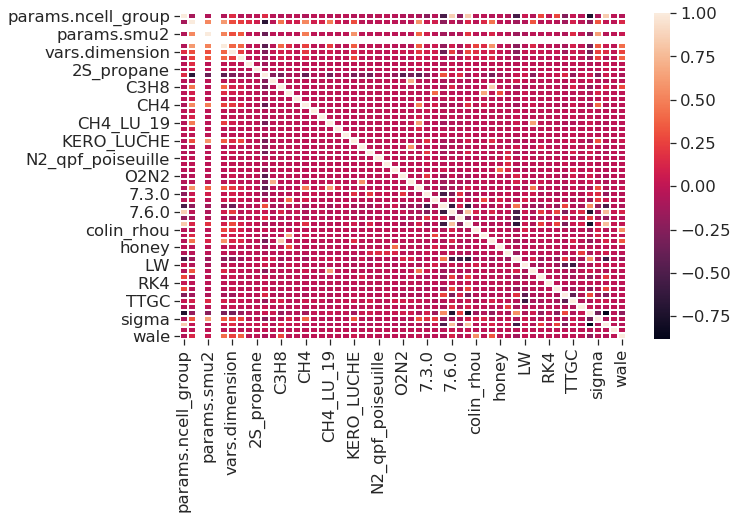

In [86]:
plt.figure(figsize = (10,6))
sns.heatmap(df_pca.corr(), linecolor = 'white', linewidth = 1)

In [87]:
#df_pca.corr()['converged'].sort_values()[:-3].plot(kind = 'bar')
#['converged'][:-4].sort_values()
#.plot(kind = 'bar')

## Kmeans with 3 clusters with highlight of converged/not converged

In [88]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[0 1 0 ... 0 0 0]


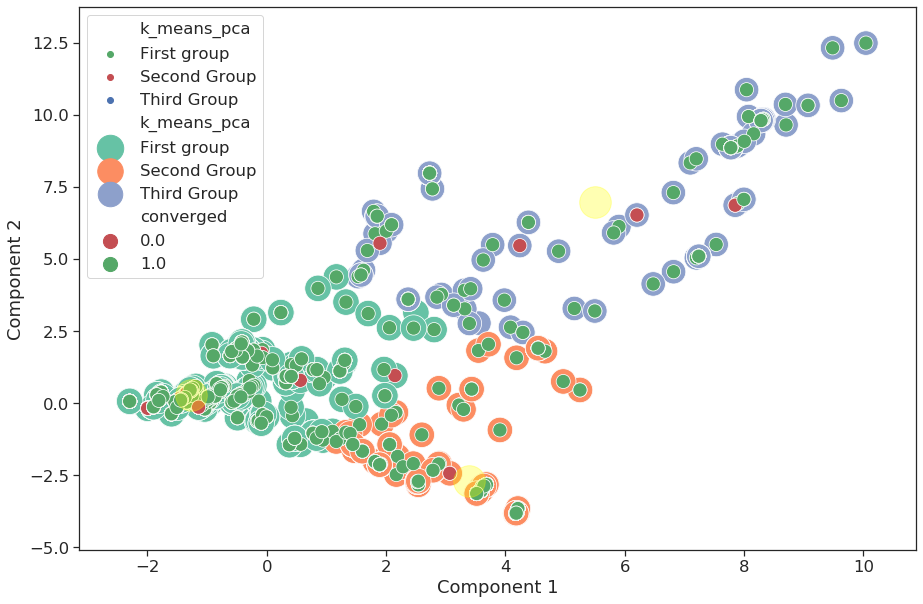

In [89]:
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (15,10))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
                palette = ['g', 'r', 'b'], alpha = 0.6)

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'],
                sizes= (600,700), palette="Set2")

sns.scatterplot(x, y, hue = df_pca_c['converged'], 
                size = df_pca_c['converged'],
               sizes = (200,200), palette = ['r', 'g'])

plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)


## PCA with 4 components

We know that a PCA with 4 components should optimize the standard deviation kept in the dimension reduction.

In [90]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']

scores_pca stores the projections of each run in the new frame system.
PCA_components stores the linear coefficients of each PCA component of the original features.

In [91]:
pca4 = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
pca4['PCA components'] = [0, 1, 2, 3]
pca4.set_index('PCA components')
pca4['KERO_LUCHE']

0    0.099683
1    0.164824
2    0.091856
3    0.137390
Name: KERO_LUCHE, dtype: float64

In [92]:
scores_pca

array([[-1.89670004, -0.12546554,  0.08788974,  0.18264638],
       [ 2.05955215, -1.43424598, -0.39585639,  0.77868011],
       [-1.4417926 ,  0.10469346,  0.16169498,  0.28387928],
       ...,
       [ 1.30905359,  1.48583391, -0.27371329,  2.70020907],
       [-1.80699977,  0.09576994,  0.1111564 , -0.40611492],
       [-1.4417926 ,  0.10469346,  0.16169498,  0.28387928]])

for the first component of PCA, we can see that the most important features are params.ncell_group, params.smu2, vars.MPI_processes, vars.dimension, vars.nodes and AIR.

In [93]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[-1.89670004  2.05955215 -1.4417926  ...  1.30905359 -1.80699977
 -1.4417926 ]
[-0.12546554 -1.43424598  0.10469346 ...  1.48583391  0.09576994
  0.10469346]
55


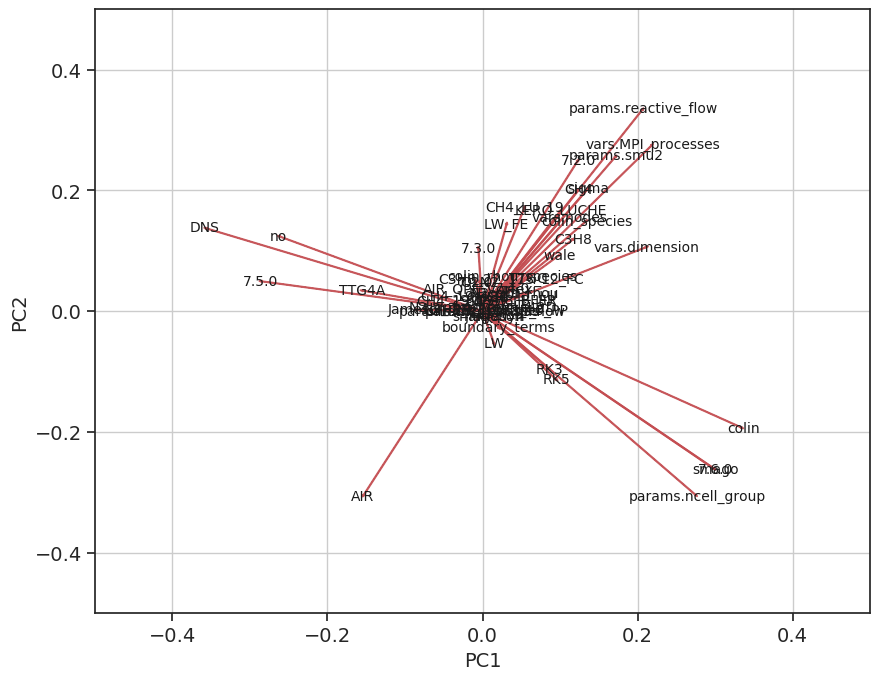

In [94]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [95]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,2] # projection on PC1
    print(x)
    y = scores_pca[:,3] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,2], coeff[i,3], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,2]*1.01, coeff[i,3]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(3), size=14)
    plt.ylabel("PC{}".format(4), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[ 0.08788974 -0.39585639  0.16169498 ... -0.27371329  0.1111564
  0.16169498]
[ 0.18264638  0.77868011  0.28387928 ...  2.70020907 -0.40611492
  0.28387928]
55


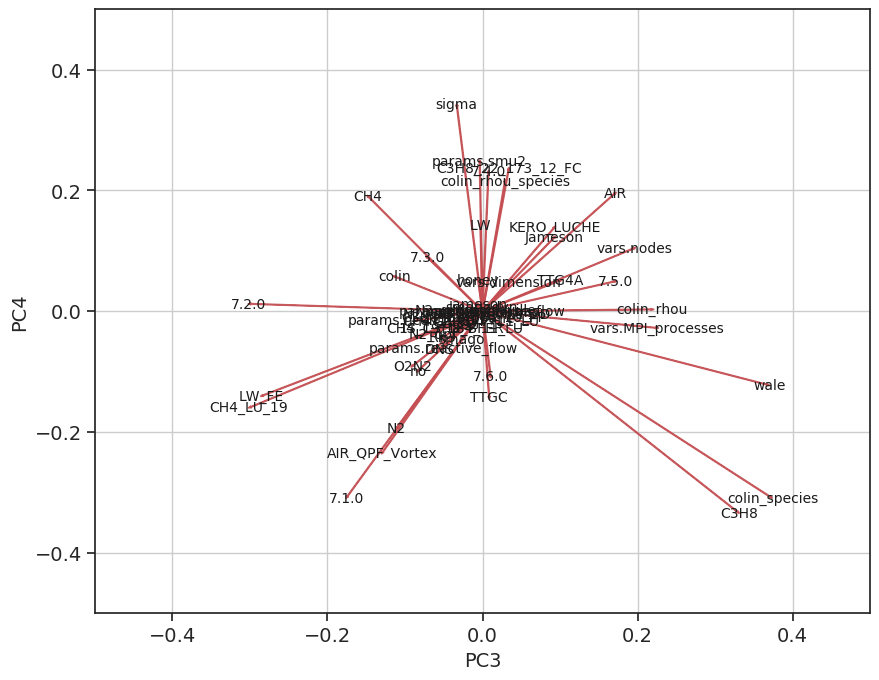

In [96]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [97]:
df_comp.head()

params.ncell_group  params.reactive_flow  params.real_gas  params.smu2  \
0                 100                   0.0              0.0          0.0   
1                  40                   0.0              0.0          0.0   
2                 100                   0.0              0.0          0.0   
3                 100                   0.0              0.0          0.0   
4                  60                   1.0              0.0          0.0   

   params.two_phase_flow  vars.MPI_processes  vars.dimension  vars.nodes  \
0                    0.0                   1               1           1   
1                    0.0                   2               2           2   
2                    0.0                   2               2           2   
3                    0.0                  36               2        1802   
4                    0.0                 540               2      961367   

   1S_C3H8_BFER  2S_propane  ...  boundary_terms  DNS  sigma  smago  smagodyn  \
0             0           0  ...               0    1      0      0         0   
1             0           0  ...               0    0      0      1         0   
2             0           0  ...               0    1      0      0         0   
3             0           0  ...               0    1      0      0         0   
4             0           0  ...               0    0      0      1         0   

   wale  Component 1  Component 2  Component 3  Component 4  
0     0    -1.896700    -0.125466     0.087890     0.182646  
1     0     2.059552    -1.434246    -0.395856     0.778680  
2     0    -1.441793     0.104693     0.161695     0.283879  
3     0    -1.768415     0.385512     0.478019     0.100904  
4     0     7.240342     5.095212     7.592322    -7.847380  

[5 rows x 59 columns]

In [98]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[0 1 0 ... 0 0 0]


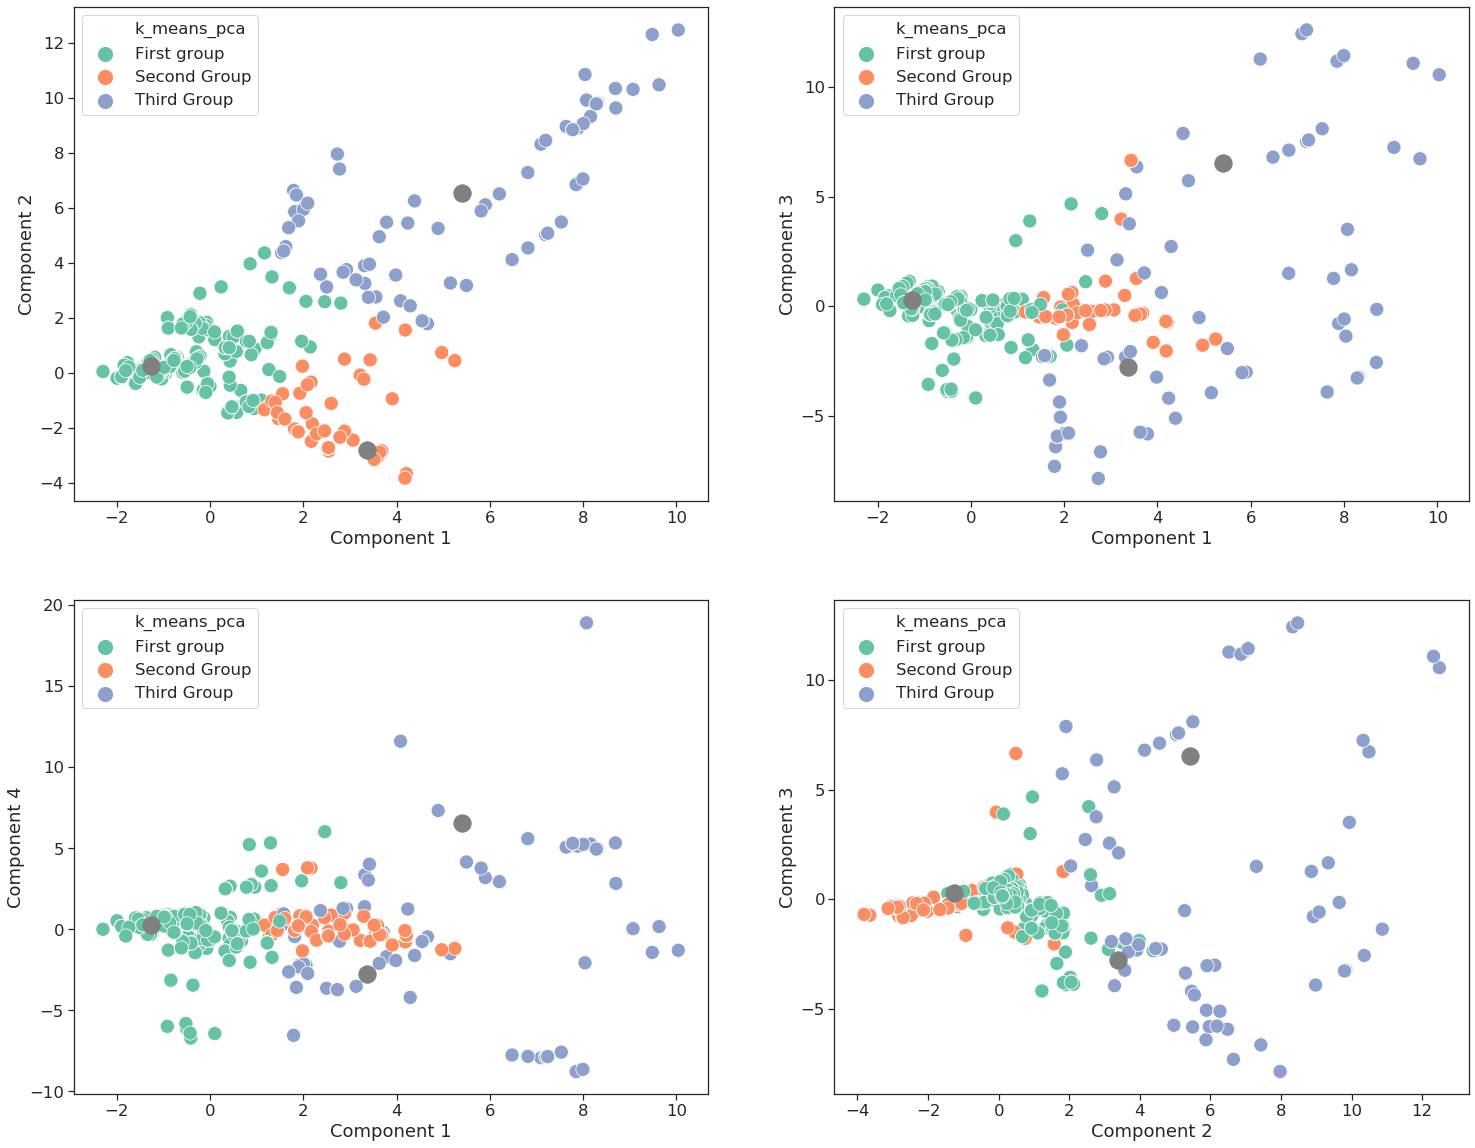

In [99]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp['Component 1']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp['Component 2']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

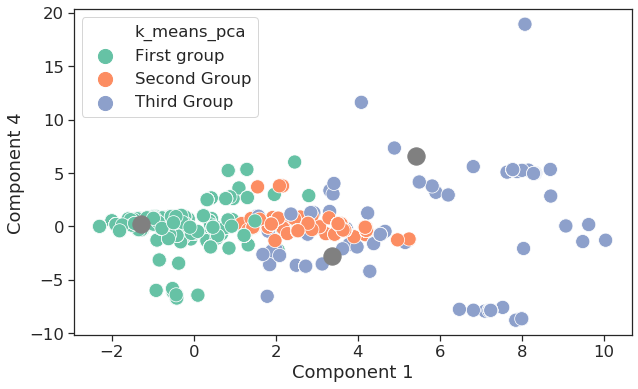

In [100]:
fig = plt.figure(figsize = (10,6))
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

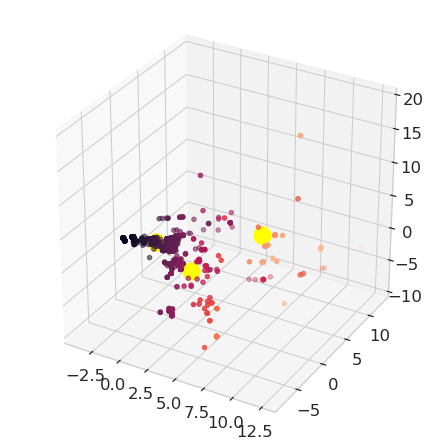

In [101]:
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
#ax = fig.add_subplot(111, projection='3d') # Method 2

x = df_comp['Component 2']
y = df_comp['Component 3']
z = df_comp['Component 4']

#sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
#                sizes= (100,200), palette="Set2")
ax.scatter(x, y, z, c = x, marker='o')

ax.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='yellow', label = 'Centroids')

ax.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='yellow', label = 'Centroids')

ax.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='yellow', label = 'Centroids')

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')

plt.show()

In [102]:
df_comp3 = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2', 'Component 3', 'Component 4'], axis = 1)
df_comp3.groupby('k_means_pca').mean()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group           122.580991     0.000000            8.763498   
Second Group         8675.075885     0.000000           19.482293   
Third Group            55.569620     0.278481          344.930380   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         1.739402  4.647009e+04      0.000892    0.000000   
Second Group        2.010118  2.933489e+04      0.005059    0.001686   
Third Group         2.550633  3.378960e+06      0.006329    0.000000   

                   AIR  AIR_QPF_Vortex      C3H8  ...       RK4       RK5  \
k_means_pca                                       ...                       
First group   0.929050        0.008478  0.000000  ...  0.000000  0.000000   
Second Group  0.986509        0.000000  0.000000  ...  0.003373  0.099494   
Third Group   0.107595        0.000000  0.189873  ...  0.000000  0.000000   

                 TTG4A      TTGC  boundary_terms       DNS     sigma  \
k_means_pca                                                            
First group   0.297635  0.347166        0.003124  0.975011  0.017403   
Second Group  0.001686  0.342327        0.025295  0.139966  0.000000   
Third Group   0.025316  0.500000        0.000000  0.373418  0.291139   

                 smago  smagodyn      wale  
k_means_pca                                 
First group   0.006693  0.000000  0.000892  
Second Group  0.848229  0.001686  0.010118  
Third Group   0.170886  0.000000  0.164557  

[3 rows x 52 columns]

In [103]:
df_comp3.groupby('k_means_pca').std()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group           311.567935     0.000000           15.442183   
Second Group         3382.417180     0.000000           29.378991   
Third Group            24.019463     0.449677          295.829205   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         0.455037  3.406622e+05      0.029867    0.000000   
Second Group        0.192509  2.252427e+05      0.071007    0.041065   
Third Group         0.499011  7.611815e+06      0.079556    0.000000   

                   AIR  AIR_QPF_Vortex      C3H8  ...       RK4       RK5  \
k_means_pca                                       ...                       
First group   0.256799        0.091707  0.000000  ...  0.000000  0.000000   
Second Group  0.115461        0.000000  0.000000  ...  0.058026  0.299577   
Third Group   0.310853        0.000000  0.393448  ...  0.000000  0.000000   

                 TTG4A      TTGC  boundary_terms       DNS     sigma  \
k_means_pca                                                            
First group   0.457320  0.476175        0.055814  0.156126  0.130796   
Second Group  0.041065  0.474889        0.157153  0.347245  0.000000   
Third Group   0.157584  0.501590        0.000000  0.485250  0.455732   

                 smago  smagodyn      wale  
k_means_pca                                 
First group   0.081557  0.000000  0.029867  
Second Group  0.359101  0.041065  0.100163  
Third Group   0.377606  0.000000  0.371959  

[3 rows x 52 columns]

In [104]:
dataframe = pd.concat([df_comp3[df_comp3['k_means_pca'] == 'First group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'First group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
dataframe.sort_values(by ='Mean Second group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.nodes                46470.091031    340662.223846       29334.893761   
params.ncell_group          122.580991       311.567935        8675.075885   
vars.MPI_processes            8.763498        15.442183          19.482293   
vars.dimension                1.739402         0.455037           2.010118   
AIR                           0.929050         0.256799           0.986509   
colin                         0.012494         0.111103           0.976391   
7.6.0                         0.029897         0.170342           0.952782   
smago                         0.006693         0.081557           0.848229   
LW                            0.345828         0.475744           0.443508   
TTGC                          0.347166         0.476175           0.342327   
DNS                           0.975011         0.156126           0.139966   
RK5                           0.000000         0.000000           0.099494   
RK3                           0.001339         0.036572           0.084317   
7.3.0                         0.222668         0.416130           0.038786   
boundary_terms                0.003124         0.055814           0.025295   
wale                          0.000892         0.029867           0.010118   
jameson                       0.015618         0.124020           0.008432   
colin_rhou                    0.000892         0.029867           0.006745   
Jameson                       0.217314         0.412510           0.006745   
7.4.0                         0.003570         0.059655           0.006745   
1S_C3H8_BFER                  0.000892         0.029867           0.005059   
N2_qpf                        0.014726         0.120479           0.005059   
RK4                           0.000000         0.000000           0.003373   
no                            0.752343         0.431748           0.001686   
C3H8_23_173_10_PP             0.000000         0.000000           0.001686   
7.2.0                         0.000000         0.000000           0.001686   
TTG4A                         0.297635         0.457320           0.001686   
2S_propane                    0.000000         0.000000           0.001686   
smagodyn                      0.000000         0.000000           0.001686   
honey                         0.001339         0.036572           0.000000   
C3H8                          0.000000         0.000000           0.000000   
AIR_QPF_Vortex                0.008478         0.091707           0.000000   
LW_FE                         0.004909         0.069904           0.000000   
CH4                           0.000446         0.021124           0.000000   
sigma                         0.017403         0.130796           0.000000   
C3H8_22_173_12_FC             0.000000         0.000000           0.000000   
GRI30                         0.000000         0.000000           0.000000   
colin_species                 0.000000         0.000000           0.000000   
H2_O2                         0.000446         0.021124           0.000000   
CH4_19_177_11_LU              0.000446         0.021124           0.000000   
CH4_19_184_11_LU              0.000446         0.021124           0.000000   
7.5.0                         0.727354         0.445420           0.000000   
CH4_LU_19                     0.000000         0.000000           0.000000   
params.smu2                   0.000000         0.000000           0.000000   
7.1.0                         0.016510         0.127456           0.000000   
O2N2                          0.028112         0.165331           0.000000   
O2                            0.005355         0.072996           0.000000   
N2_qpf_poiseuille_2D          0.000446         0.021124           0.000000   
N2_qpf_poiseuille             0.000446         0.021124           0.000000   
N2                            0.007140         0.084213           0.000000   
KERO_LUCHE                    0.003570      


# Kmeans = 4

In [105]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans = KMeans(n_clusters = 4)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[1 0 1 ... 1 1 1]


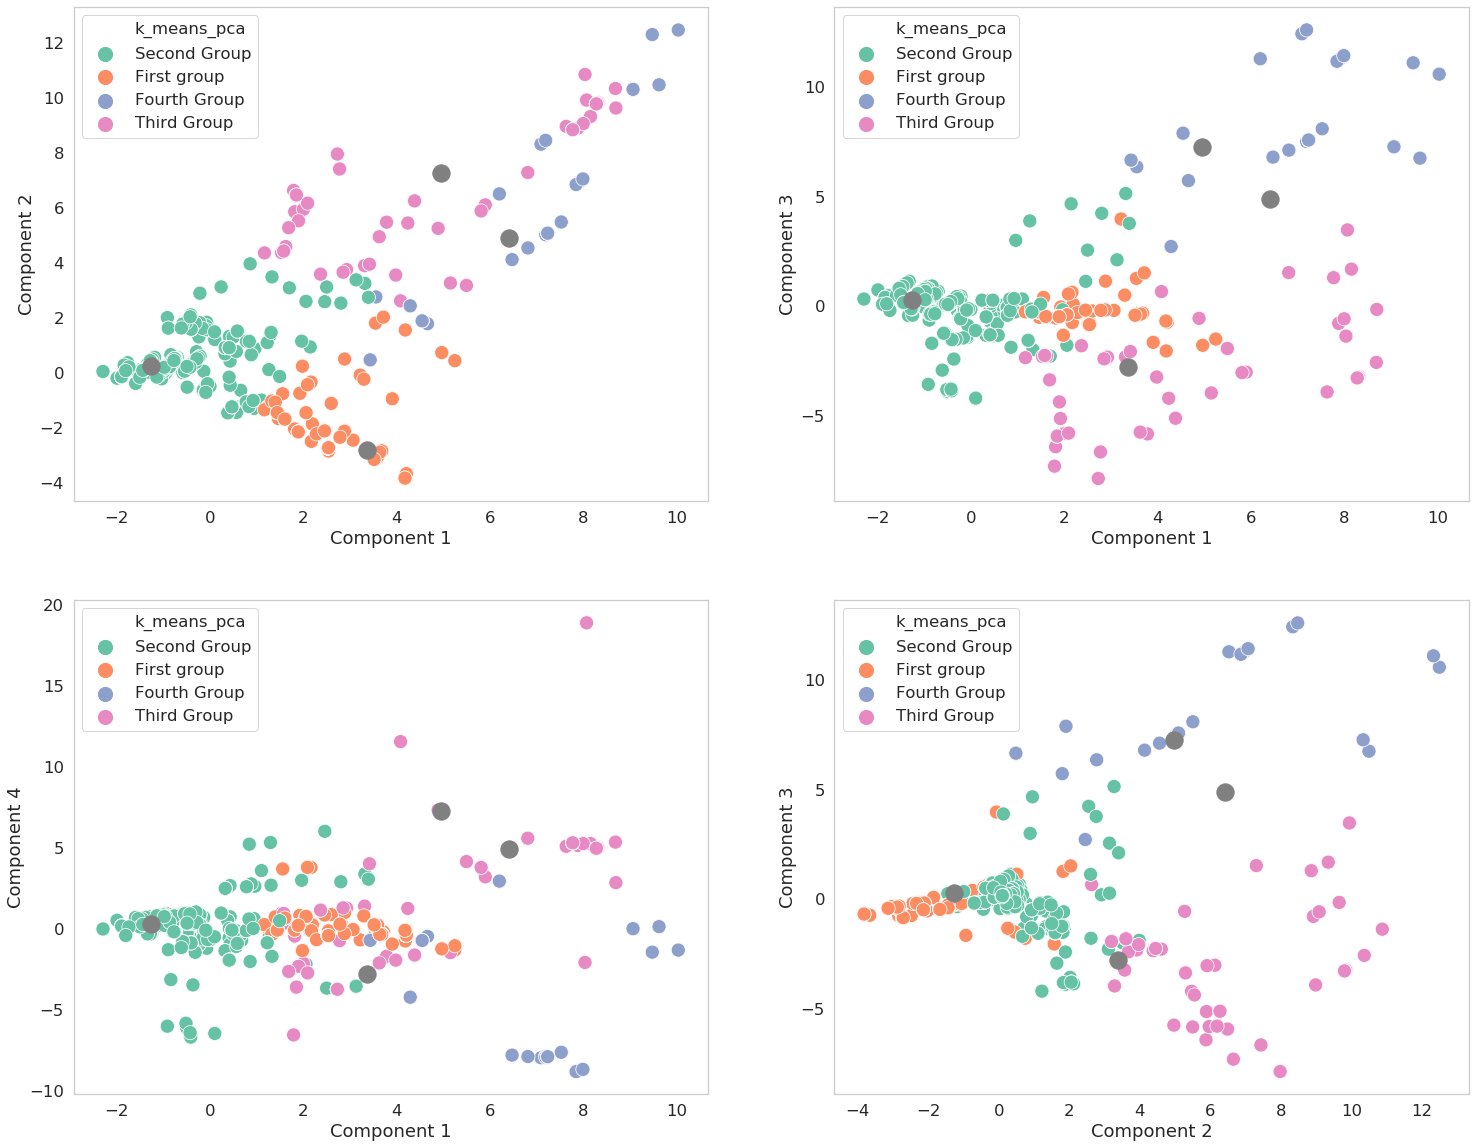

In [106]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group', 
                                                     3: 'Fourth Group'})

fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp['Component 1']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp['Component 2']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

In [107]:
df_comp = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2', 'Component 3', 'Component 4'], axis = 1)
df_comp.groupby('k_means_pca').mean()

params.ncell_group  params.smu2  vars.MPI_processes  \
k_means_pca                                                         
First group          8719.084746     0.000000           19.133898   
Fourth Group           56.560000     0.100000          522.400000   
Second Group          122.430290     0.000000            9.100668   
Third Group            54.766355     0.364486          260.289720   

              vars.dimension    vars.nodes  1S_C3H8_BFER  2S_propane  \
k_means_pca                                                            
First group         2.005085  3.112676e+04      0.005085    0.001695   
Fourth Group        2.640000  5.284152e+06      0.000000    0.000000   
Second Group        1.741203  5.337325e+04      0.000891    0.000000   
Third Group         2.514019  2.364630e+06      0.009346    0.000000   

                   AIR  AIR_QPF_Vortex      C3H8  ...      RK4  RK5     TTG4A  \
k_means_pca                                       ...                           
First group   0.986441        0.000000  0.000000  ...  0.00339  0.1  0.001695   
Fourth Group  0.360000        0.000000  0.540000  ...  0.00000  0.0  0.080000   
Second Group  0.928285        0.008463  0.001336  ...  0.00000  0.0  0.297105   
Third Group   0.000000        0.000000  0.000000  ...  0.00000  0.0  0.000000   

                  TTGC  boundary_terms       DNS     sigma     smago  \
k_means_pca                                                            
First group   0.344068        0.025424  0.140678  0.000000  0.852542   
Fourth Group  0.580000        0.000000  0.000000  0.000000  0.420000   
Second Group  0.346102        0.003118  0.974165  0.018263  0.006682   
Third Group   0.476636        0.000000  0.532710  0.411215  0.056075   

              smagodyn      wale  
k_means_pca                       
First group   0.001695  0.005085  
Fourth Group  0.000000  0.580000  
Second Group  0.000000  0.000891  
Third Group   0.000000  0.000000  

[4 rows x 52 columns]

In [108]:
dataframe = pd.concat([df_comp[df_comp['k_means_pca'] == 'First group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'First group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Fourth Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Fourth Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group',
                     'Mean Fourth group', 'Mean Fourth Group']
dataframe.sort_values(by ='Mean Third group', ascending = False)

Mean First group  Std First Group  Mean Second group  \
vars.nodes                31126.759322    239473.432842       53373.252561   
vars.MPI_processes           19.133898        29.132518           9.100668   
params.ncell_group         8719.084746      3333.997510         122.430290   
vars.dimension                2.005085         0.179533           1.741203   
colin                         0.983051         0.129190           0.013808   
7.2.0                         0.003390         0.058173           0.000000   
DNS                           0.140678         0.347984           0.974165   
TTGC                          0.344068         0.475466           0.346102   
CH4                           0.000000         0.000000           0.000000   
sigma                         0.000000         0.000000           0.018263   
no                            0.001695         0.041169           0.750557   
params.smu2                   0.000000         0.000000           0.000000   
CH4_LU_19                     0.000000         0.000000           0.000000   
7.3.0                         0.038983         0.193719           0.223163   
LW                            0.440678         0.496890           0.347439   
LW_FE                         0.000000         0.000000           0.004900   
KERO_LUCHE                    0.000000         0.000000           0.003563   
7.5.0                         0.000000         0.000000           0.726949   
smago                         0.852542         0.354862           0.006682   
7.4.0                         0.006780         0.082129           0.003563   
colin_rhou_species            0.000000         0.000000           0.000000   
C3H8_22_173_12_FC             0.000000         0.000000           0.000000   
honey                         0.000000         0.000000           0.001336   
7.1.0                         0.000000         0.000000           0.016481   
GRI30                         0.000000         0.000000           0.000000   
CH4_19_184_11_LU              0.000000         0.000000           0.000445   
7.6.0                         0.950847         0.216370           0.029844   
1S_C3H8_BFER                  0.005085         0.071186           0.000891   
RK5                           0.100000         0.300255           0.000000   
RK4                           0.003390         0.058173           0.000000   
RK3                           0.084746         0.278739           0.001336   
boundary_terms                0.025424         0.157542           0.003118   
smagodyn                      0.001695         0.041169           0.000000   
jameson                       0.008475         0.091744           0.015590   
TTG4A                         0.001695         0.041169           0.297105   
2S_propane                    0.001695         0.041169           0.000000   
colin_species                 0.000000         0.000000           0.000000   
colin_rhou                    0.000000         0.000000           0.001782   
Jameson                       0.006780         0.082129           0.216927   
AIR                           0.986441         0.115750           0.928285   
O2N2                          0.000000         0.000000           0.028062   
O2                            0.000000         0.000000           0.005345   
N2_qpf_poiseuille_2D          0.000000         0.000000           0.000445   
N2_qpf_poiseuille             0.000000         0.000000           0.000445   
N2_qpf                        0.005085         0.071186           0.014699   
N2                            0.000000         0.000000           0.007127   
H2_O2                         0.000000         0.000000           0.000445   
CH4_19_177_11_LU              0.000000         0.000000           0.000445   
C3H8_23_173_10_PP             0.001695         0.041169           0.000000   
C3H8                          0.000000         0.000000           0.001336   
AIR_QPF_Vortex                0.000000      

# Decision Tree 

In [109]:
df_pca_c

params.ncell_group  params.reactive_flow  params.real_gas  \
index_run                                                              
0                         100                   0.0              0.0   
1                          40                   0.0              0.0   
2                         100                   0.0              0.0   
3                         100                   0.0              0.0   
4                          60                   1.0              0.0   
5                         100                   0.0              0.0   
6                         100                   0.0              0.0   
8                         100                   0.0              0.0   
9                         100                   1.0              0.0   
10                        100                   0.0              0.0   
11                        100                   0.0              0.0   
12                        100                   0.0              0.0   
13                        100                   0.0              0.0   
14                        100                   0.0              0.0   
15                        100                   0.0              0.0   
16                        400                   0.0              0.0   
17                        100                   0.0              0.0   
18                      10000                   0.0              0.0   
19                        100                   0.0              0.0   
20                        100                   1.0              0.0   
21                      10000                   0.0              0.0   
22                        100                   0.0              0.0   
23                      10000                   0.0              0.0   
24                      10000                   0.0              0.0   
25                        100                   0.0              0.0   
26                        100                   0.0              0.0   
27                        100                   0.0              0.0   
28                         60                   1.0              0.0   
29                         40                   0.0              0.0   
31                        100                   0.0              0.0   
...                       ...                   ...              ...   
3186                      100                   0.0              0.0   
3188                      100                   0.0              0.0   
3189                      100                   0.0              0.0   
3190                      100                   0.0              0.0   
3191                      100                   0.0              0.0   
3192                    10000                   0.0              0.0   
3193                      100                   0.0              0.0   
3194                      100                   0.0              0.0   
3195                      100                   0.0              0.0   
3197                      100                   0.0              0.0   
3198                       40                   1.0              0.0   
3199                      100                   0.0              0.0   
3200                      100                   0.0              0.0   
3201                      100                   0.0              0.0   
3202                      100                   0.0              0.0   
3203                      100                   0.0              0.0   
3204                    10000                   0.0              0.0   
3205                      100                   0.0              0.0   
3206                      100                   0.0              0.0   
3207                      100                   0.0              0.0   
3208                      100                   0.0              0.0   
3209                      100                   0.0              0.0   
3210                    10000                   0.0

In [110]:
from sklearn.model_selection import train_test_split

In [111]:
X = df_pca_c.drop('converged', axis = 1)

In [112]:
y = df_pca_c['converged']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [114]:
X_train

params.ncell_group  params.reactive_flow  params.real_gas  \
index_run                                                              
2431                      100                   0.0              0.0   
851                       100                   0.0              0.0   
2541                      100                   0.0              0.0   
333                        40                   1.0              0.0   
1581                      400                   0.0              0.0   
1241                      100                   0.0              0.0   
337                       100                   0.0              0.0   
2735                      100                   0.0              0.0   
1938                    10000                   0.0              0.0   
2316                      100                   0.0              0.0   
721                     10000                   0.0              0.0   
2609                      100                   0.0              0.0   
247                     10000                   0.0              0.0   
1757                      100                   0.0              0.0   
1285                      100                   0.0              0.0   
3199                      100                   0.0              0.0   
491                       100                   0.0              0.0   
1586                      100                   0.0              0.0   
1704                      100                   0.0              0.0   
2402                      100                   0.0              0.0   
91                        100                   0.0              0.0   
3152                      100                   0.0              0.0   
844                       100                   0.0              0.0   
1025                      100                   0.0              0.0   
1049                      100                   0.0              0.0   
915                       100                   0.0              0.0   
1432                       40                   0.0              0.0   
675                       100                   0.0              0.0   
2552                      100                   0.0              0.0   
2547                      400                   0.0              0.0   
...                       ...                   ...              ...   
1184                    10000                   0.0              0.0   
516                       100                   0.0              0.0   
3121                      400                   0.0              0.0   
810                       100                   0.0              0.0   
2477                      100                   0.0              0.0   
22                        100                   0.0              0.0   
501                       100                   0.0              0.0   
1291                      100                   0.0              0.0   
2505                    10000                   0.0              0.0   
1043                    10000                   0.0              0.0   
1324                    10000                   0.0              0.0   
2618                    10000                   0.0              0.0   
3067                      100                   0.0              0.0   
1647                      100                   0.0              0.0   
2574                      100                   0.0              0.0   
835                        40                   0.0              0.0   
1829                      100                   0.0              0.0   
145                     10000                   0.0              0.0   
3137                    10000                   0.0              0.0   
2302                    10000                   0.0              0.0   
1613                      100                   0.0              0.0   
366                     10000                   0.0              0.0   
1349                      100                   0.0

In [115]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import classification_report,confusion_matrix

In [116]:
X_test

params.ncell_group  params.reactive_flow  params.real_gas  \
index_run                                                              
451                       100                   0.0              0.0   
2877                      100                   0.0              0.0   
1483                      100                   0.0              0.0   
56                        100                   0.0              0.0   
1752                      400                   0.0              0.0   
2171                      100                   0.0              0.0   
2682                      100                   0.0              0.0   
68                        100                   0.0              0.0   
620                       100                   0.0              0.0   
2343                      400                   0.0              0.0   
213                       100                   0.0              0.0   
3201                      100                   0.0              0.0   
2830                      100                   0.0              0.0   
1281                      100                   0.0              0.0   
3028                      100                   0.0              0.0   
1046                    10000                   0.0              0.0   
2474                       40                   0.0              0.0   
1009                       40                   1.0              0.0   
820                       100                   0.0              0.0   
1197                      100                   0.0              0.0   
2849                      100                   0.0              0.0   
2268                       36                   0.0              0.0   
2134                      100                   0.0              0.0   
982                       100                   0.0              0.0   
2257                       40                   1.0              0.0   
615                     10000                   0.0              0.0   
2594                      100                   0.0              0.0   
2586                      100                   0.0              0.0   
432                       100                   0.0              0.0   
287                     10000                   0.0              0.0   
...                       ...                   ...              ...   
2549                      100                   0.0              0.0   
1605                      100                   0.0              0.0   
1201                       40                   0.0              0.0   
871                       100                   0.0              0.0   
855                       100                   0.0              0.0   
2890                      100                   0.0              0.0   
3108                      100                   0.0              0.0   
857                       100                   0.0              0.0   
2479                      100                   0.0              0.0   
2336                    10000                   0.0              0.0   
2501                      100                   0.0              0.0   
773                       100                   0.0              0.0   
874                       100                   0.0              0.0   
2905                      100                   0.0              0.0   
3054                      100                   0.0              0.0   
137                       100                   0.0              0.0   
1383                      100                   0.0              0.0   
1962                      400                   0.0              0.0   
1547                       40                   0.0              0.0   
671                       100                   0.0              0.0   
446                       100                   0.0              0.0   
2963                      100                   0.0              0.0   
1192                      100                   0.0

In [117]:
dtree = DecisionTreeClassifier()

In [118]:
dtree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [119]:
predictions = dtree.predict(X_test)

In [120]:
print(confusion_matrix(y_test, predictions))

[[ 23  10]
 [  4 951]]


In [121]:
print(np.array(predictions))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [122]:
print(np.array(y_test))

[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [123]:
dir(dtree)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_prune_tree',
 '_validate_X_predict',
 'apply',
 'ccp_alpha',
 'class_weight',
 'classes_',
 'cost_complexity_pruning_path',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fr

In [124]:
dtree.feature_importances_.shape
print(len(df_pca_c.columns))

56


In [125]:
pd.DataFrame(dtree.feature_importances_.reshape(1,26), columns = X.columns)

ValueError: cannot reshape array of size 55 into shape (1,26)

In [ ]:
text_representation = export_text(dtree)
print(text_representation)

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dtree, 
                   feature_names=X.columns, 
                   filled=True)